<h1> Node Classification using Graph Convolutional Networks </h1>

This node classification task uses CORA dataset from https://linqs.soe.ucsc.edu/data<br>
The dataset consists of <b>2708</b> nodes which correspond to scientific publications.<br>
The nodes are classified into <b>7</b> categories indicating the topics of each document.<br>
The edges indicate whether a document is cited by the other or vice versa.<br>
Each node has <b>1433</b> features which is described by a 0/1-valued vector, indicating the bag-of-words from the dictionary.<br>

<br> This is an undirected graph problem

In [1]:
#importing dependencies

import numpy as numpy
import pandas as pandas
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCNConv
from spektral.layers import GATConv
from spektral.layers import GINConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as matplot

C:\Users\Sidsavi\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Sidsavi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Sidsavi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


<h2> Data Loading and Preprocessing </h2><br>
We are going to use the edges connecting the  (from file <b>cora.cites</b>).<br>
The nodes are loaded from file <b>cora.content</b>.

In [2]:
#loading the data
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

In [3]:
random_state = 1234
all_data = shuffle(all_data,random_state=random_state)

In [4]:
all_data

['1114838\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\

In <b>cora.content</b> file:<br>
The <b>first</b> element indicates the <b>node name</b><br>
The <b>second</b> until the last second elements indicate the <b>node features</b><br>
The <b>last</b> element indicates the <b>label of that particular node</b><br>

In <b>cora.cites</b> file:<br>
Each line indicates the tuple of connected nodes


<h3>Parsing the data</h3>

In [5]:
#parse the data
target_class = []
nodes = []
nodes_features = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    target_class.append(elements[-1])
    nodes_features.append(elements[1:-1])
    nodes.append(elements[0])
    
nodes_features = numpy.array(nodes_features,dtype=int)
Num_Nodes = nodes_features.shape[0] #the number of nodes
Num_Nodes_Features = nodes_features.shape[1] #the size of node features
print('nodes_features shape: ', nodes_features.shape)

edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))
    
print('\nNumber of nodes (N): ', Num_Nodes)
print('\nNumber of features (F) of each node: ', Num_Nodes_Features)
print('\nCategories: ', set(target_class))

num_classes = len(set(target_class))
print('\nNumber of classes: ', num_classes)

nodes_features shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Rule_Learning', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Genetic_Algorithms', 'Case_Based', 'Theory'}

Number of classes:  7


In [6]:
pandas.DataFrame(nodes_features).to_csv("Cora_node_features.csv")

In [7]:
pandas.DataFrame(nodes).to_csv("Cora_nodes.csv")

In [8]:
pandas.DataFrame(target_class).to_csv("Cora_labels.csv")

In [9]:
pandas.DataFrame(edge_list).to_csv("Cora_Edge_list.csv")

<h3>Build a graph on NetworkX using the obtained nodes and edges list</h3>

In [10]:
#build the graph
Graph = nx.Graph()
Graph.add_nodes_from(nodes)
Graph.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
Adjacency = nx.adjacency_matrix(Graph)
print('Graph info: ', nx.info(Graph))

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


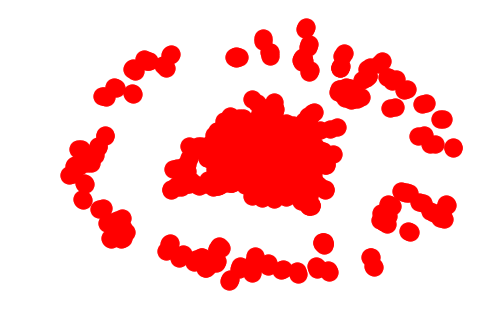

In [11]:
nx.draw(Graph)

<h3> Select examples for training, validation, and test then set the mask</h3>

In [12]:
def Split_data_for_Training(target_class,Number_of_Samples_per_class=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    Counter_target_class = dict((l, 0) for l in target_class)
    train_idx = []

    for i in range(len(target_class)):
        label = target_class[i]
        if Counter_target_class[label]<Number_of_Samples_per_class:
            #add the example to the training data
            train_idx.append(i)
            Counter_target_class[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == Number_of_Samples_per_class for count in Counter_target_class.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(target_class)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx

In [13]:
train_idx,val_idx,test_idx = Split_data_for_Training(target_class)

In [14]:
#set the mask
train_mask = numpy.zeros((Num_Nodes,),dtype=bool)
train_mask[train_idx] = True

val_mask = numpy.zeros((Num_Nodes,),dtype=bool)
val_mask[val_idx] = True

test_mask = numpy.zeros((Num_Nodes,),dtype=bool)
test_mask[test_idx] = True

<h3>Show Data Distribution</h3>

In [15]:
print("All Data Distribution: \n{}".format(Counter(target_class)))

All Data Distribution: 
Counter({'Neural_Networks': 818, 'Probabilistic_Methods': 426, 'Genetic_Algorithms': 418, 'Theory': 351, 'Case_Based': 298, 'Reinforcement_Learning': 217, 'Rule_Learning': 180})


In [16]:
print("Training Data Distribution: \n{}".format(Counter([target_class[i] for i in train_idx])))

Training Data Distribution: 
Counter({'Theory': 20, 'Reinforcement_Learning': 20, 'Neural_Networks': 20, 'Genetic_Algorithms': 20, 'Probabilistic_Methods': 20, 'Rule_Learning': 20, 'Case_Based': 20})


In [17]:
print("Validation Data Distribution: \n{}".format(Counter([target_class[i] for i in val_idx])))

Validation Data Distribution: 
Counter({'Neural_Networks': 180, 'Genetic_Algorithms': 85, 'Theory': 74, 'Probabilistic_Methods': 63, 'Case_Based': 44, 'Reinforcement_Learning': 30, 'Rule_Learning': 24})


<h3>Convert the labels to one hot encoding</h3>

In [18]:
def encode_label(target_class):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(target_class)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(target_class)

In [19]:
len(labels_encoded)

2708

In [20]:
classes

array(['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], dtype='<U22')

In [21]:
labels_encoded = to_categorical(labels_encoded)

In [22]:
labels_encoded

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
pandas.DataFrame(labels_encoded).head()

0    1    2    3    4    5    6
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0
4  0.0  0.0  1.0  0.0  0.0  0.0  0.0

In [24]:
classes

array(['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], dtype='<U22')

<h2> Building and Training Graph Convolutional Networks </h2>

In [25]:
channels = 48           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-4    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 100       # Patience for early stopping

# Preprocessing operations
A = GCNConv.preprocess(Adjacency).astype('f4')

# Model definition
X_in = Input(shape=(Num_Nodes_Features, ))
fltr_in = Input((Num_Nodes, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(24,
                         activation='relu',kernel_regularizer=l2(l2_reg),
                         use_bias=True)([dropout_2, fltr_in])

dropout_3 = Dropout(dropout)(graph_conv_2)
graph_conv_3 = GCNConv(16,
                         activation='relu',kernel_regularizer=l2(l2_reg),
                         use_bias=True)([dropout_3, fltr_in])

graph_conv_4 = GCNConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_3, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_4)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________

In [26]:
# Train model
validation_data = ([nodes_features, A], labels_encoded, val_mask)
validation_data

([array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  <2708x2708 sparse matrix of type '<class 'numpy.float32'>'
  	with 13264 stored elements in Compressed Sparse Row format>],
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([False, False, False, ..., False, False, False]))

In [27]:
channels = 48           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4          # L2 regularization rate
learning_rate = 1e-5    # Learning rate
epochs = 500            # Number of training epochs
es_patience = 100       # Patience for early stopping

In [28]:
model.fit([nodes_features, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=Num_Nodes,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - ETA: 0s - loss: 0.1634 - acc: 0.0929WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000027BF7CCA7B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

1/1 [==============================] - ETA: 0s - loss: 0.1560 - acc: 0.235 - 0s 266ms/step - loss: 0.1560 - acc: 0.2357 - val_loss: 0.4151 - val_acc: 0.1620
Epoch 39/500
1/1 [==============================] - ETA: 0s - loss: 0.1558 - acc: 0.178 - 0s 225ms/step - loss: 0.1558 - acc: 0.1786 - val_loss: 0.4149 - val_acc: 0.1660
Epoch 40/500
1/1 [==============================] - ETA: 0s - loss: 0.1551 - acc: 0.242 - 0s 226ms/step - loss: 0.1551 - acc: 0.2429 - val_loss: 0.4147 - val_acc: 0.1740
Epoch 41/500
1/1 [==============================] - ETA: 0s - loss: 0.1554 - acc: 0.200 - 0s 225ms/step - loss: 0.1554 - acc: 0.2000 - val_loss: 0.4145 - val_acc: 0.1760
Epoch 42/500
1/1 [==============================] - ETA: 0s - loss: 0.1549 - acc: 0.221 - 0s 228ms/step - loss: 0.1549 - acc: 0.2214 - val_loss: 0.4142 - val_acc: 0.1780
Epoch 43/500
1/1 [==============================] - ETA: 0s - loss: 0.1549 - acc: 0.264 - 0s 225ms/step - loss: 0.1549 - acc: 0.2643 - val_loss: 0.4140 - val_acc: 

1/1 [==============================] - ETA: 0s - loss: 0.1473 - acc: 0.328 - 0s 247ms/step - loss: 0.1473 - acc: 0.3286 - val_loss: 0.4047 - val_acc: 0.3380
Epoch 87/500
1/1 [==============================] - ETA: 0s - loss: 0.1466 - acc: 0.364 - 0s 290ms/step - loss: 0.1466 - acc: 0.3643 - val_loss: 0.4045 - val_acc: 0.3440
Epoch 88/500
1/1 [==============================] - ETA: 0s - loss: 0.1460 - acc: 0.350 - 0s 226ms/step - loss: 0.1460 - acc: 0.3500 - val_loss: 0.4043 - val_acc: 0.3480
Epoch 89/500
1/1 [==============================] - ETA: 0s - loss: 0.1465 - acc: 0.314 - 0s 226ms/step - loss: 0.1465 - acc: 0.3143 - val_loss: 0.4041 - val_acc: 0.3500
Epoch 90/500
1/1 [==============================] - ETA: 0s - loss: 0.1464 - acc: 0.300 - 0s 227ms/step - loss: 0.1464 - acc: 0.3000 - val_loss: 0.4038 - val_acc: 0.3540
Epoch 91/500
1/1 [==============================] - ETA: 0s - loss: 0.1460 - acc: 0.321 - 0s 320ms/step - loss: 0.1460 - acc: 0.3214 - val_loss: 0.4036 - val_acc: 

Epoch 134/500
1/1 [==============================] - ETA: 0s - loss: 0.1390 - acc: 0.421 - 0s 219ms/step - loss: 0.1390 - acc: 0.4214 - val_loss: 0.3946 - val_acc: 0.4260
Epoch 135/500
1/1 [==============================] - ETA: 0s - loss: 0.1385 - acc: 0.442 - 0s 219ms/step - loss: 0.1385 - acc: 0.4429 - val_loss: 0.3944 - val_acc: 0.4280
Epoch 136/500
1/1 [==============================] - ETA: 0s - loss: 0.1381 - acc: 0.478 - 0s 234ms/step - loss: 0.1381 - acc: 0.4786 - val_loss: 0.3942 - val_acc: 0.4300
Epoch 137/500
1/1 [==============================] - ETA: 0s - loss: 0.1375 - acc: 0.507 - 0s 233ms/step - loss: 0.1375 - acc: 0.5071 - val_loss: 0.3939 - val_acc: 0.4320
Epoch 138/500
1/1 [==============================] - ETA: 0s - loss: 0.1372 - acc: 0.464 - 0s 239ms/step - loss: 0.1372 - acc: 0.4643 - val_loss: 0.3937 - val_acc: 0.4340
Epoch 139/500
1/1 [==============================] - ETA: 0s - loss: 0.1379 - acc: 0.378 - 0s 394ms/step - loss: 0.1379 - acc: 0.3786 - val_loss:

Epoch 182/500
1/1 [==============================] - ETA: 0s - loss: 0.1312 - acc: 0.492 - 0s 221ms/step - loss: 0.1312 - acc: 0.4929 - val_loss: 0.3836 - val_acc: 0.4860
Epoch 183/500
1/1 [==============================] - ETA: 0s - loss: 0.1316 - acc: 0.550 - 0s 219ms/step - loss: 0.1316 - acc: 0.5500 - val_loss: 0.3834 - val_acc: 0.4860
Epoch 184/500
1/1 [==============================] - ETA: 0s - loss: 0.1311 - acc: 0.507 - 0s 287ms/step - loss: 0.1311 - acc: 0.5071 - val_loss: 0.3832 - val_acc: 0.4860
Epoch 185/500
1/1 [==============================] - ETA: 0s - loss: 0.1310 - acc: 0.478 - 0s 261ms/step - loss: 0.1310 - acc: 0.4786 - val_loss: 0.3829 - val_acc: 0.4860
Epoch 186/500
1/1 [==============================] - ETA: 0s - loss: 0.1306 - acc: 0.535 - 0s 229ms/step - loss: 0.1306 - acc: 0.5357 - val_loss: 0.3827 - val_acc: 0.4880
Epoch 187/500
1/1 [==============================] - ETA: 0s - loss: 0.1302 - acc: 0.550 - 0s 220ms/step - loss: 0.1302 - acc: 0.5500 - val_loss:

Epoch 230/500
1/1 [==============================] - ETA: 0s - loss: 0.1247 - acc: 0.600 - 0s 229ms/step - loss: 0.1247 - acc: 0.6000 - val_loss: 0.3717 - val_acc: 0.5200
Epoch 231/500
1/1 [==============================] - ETA: 0s - loss: 0.1242 - acc: 0.614 - 0s 222ms/step - loss: 0.1242 - acc: 0.6143 - val_loss: 0.3715 - val_acc: 0.5200
Epoch 232/500
1/1 [==============================] - ETA: 0s - loss: 0.1239 - acc: 0.571 - 0s 228ms/step - loss: 0.1239 - acc: 0.5714 - val_loss: 0.3712 - val_acc: 0.5260
Epoch 233/500
1/1 [==============================] - ETA: 0s - loss: 0.1239 - acc: 0.592 - 0s 220ms/step - loss: 0.1239 - acc: 0.5929 - val_loss: 0.3709 - val_acc: 0.5280
Epoch 234/500
1/1 [==============================] - ETA: 0s - loss: 0.1234 - acc: 0.578 - 0s 218ms/step - loss: 0.1234 - acc: 0.5786 - val_loss: 0.3707 - val_acc: 0.5320
Epoch 235/500
1/1 [==============================] - ETA: 0s - loss: 0.1225 - acc: 0.550 - 0s 221ms/step - loss: 0.1225 - acc: 0.5500 - val_loss:

Epoch 278/500
1/1 [==============================] - ETA: 0s - loss: 0.1169 - acc: 0.642 - 0s 236ms/step - loss: 0.1169 - acc: 0.6429 - val_loss: 0.3580 - val_acc: 0.5840
Epoch 279/500
1/1 [==============================] - ETA: 0s - loss: 0.1149 - acc: 0.764 - 0s 222ms/step - loss: 0.1149 - acc: 0.7643 - val_loss: 0.3577 - val_acc: 0.5840
Epoch 280/500
1/1 [==============================] - ETA: 0s - loss: 0.1169 - acc: 0.642 - 0s 221ms/step - loss: 0.1169 - acc: 0.6429 - val_loss: 0.3574 - val_acc: 0.5840
Epoch 281/500
1/1 [==============================] - ETA: 0s - loss: 0.1166 - acc: 0.692 - 0s 221ms/step - loss: 0.1166 - acc: 0.6929 - val_loss: 0.3571 - val_acc: 0.5840
Epoch 282/500
1/1 [==============================] - ETA: 0s - loss: 0.1166 - acc: 0.664 - 0s 265ms/step - loss: 0.1166 - acc: 0.6643 - val_loss: 0.3568 - val_acc: 0.5840
Epoch 283/500
1/1 [==============================] - ETA: 0s - loss: 0.1160 - acc: 0.707 - 0s 214ms/step - loss: 0.1160 - acc: 0.7071 - val_loss:

Epoch 326/500
1/1 [==============================] - ETA: 0s - loss: 0.1109 - acc: 0.657 - 0s 237ms/step - loss: 0.1109 - acc: 0.6571 - val_loss: 0.3436 - val_acc: 0.6000
Epoch 327/500
1/1 [==============================] - ETA: 0s - loss: 0.1119 - acc: 0.671 - 0s 273ms/step - loss: 0.1119 - acc: 0.6714 - val_loss: 0.3433 - val_acc: 0.6020
Epoch 328/500
1/1 [==============================] - ETA: 0s - loss: 0.1098 - acc: 0.657 - 0s 393ms/step - loss: 0.1098 - acc: 0.6571 - val_loss: 0.3430 - val_acc: 0.6020
Epoch 329/500
1/1 [==============================] - ETA: 0s - loss: 0.1081 - acc: 0.764 - 0s 354ms/step - loss: 0.1081 - acc: 0.7643 - val_loss: 0.3427 - val_acc: 0.6040
Epoch 330/500
1/1 [==============================] - ETA: 0s - loss: 0.1113 - acc: 0.664 - 0s 348ms/step - loss: 0.1113 - acc: 0.6643 - val_loss: 0.3424 - val_acc: 0.6040
Epoch 331/500
1/1 [==============================] - ETA: 0s - loss: 0.1094 - acc: 0.700 - 0s 296ms/step - loss: 0.1094 - acc: 0.7000 - val_loss:

Epoch 374/500
1/1 [==============================] - ETA: 0s - loss: 0.1030 - acc: 0.757 - 0s 228ms/step - loss: 0.1030 - acc: 0.7571 - val_loss: 0.3295 - val_acc: 0.6200
Epoch 375/500
1/1 [==============================] - ETA: 0s - loss: 0.1040 - acc: 0.714 - 0s 237ms/step - loss: 0.1040 - acc: 0.7143 - val_loss: 0.3291 - val_acc: 0.6220
Epoch 376/500
1/1 [==============================] - ETA: 0s - loss: 0.1039 - acc: 0.721 - 0s 224ms/step - loss: 0.1039 - acc: 0.7214 - val_loss: 0.3288 - val_acc: 0.6220
Epoch 377/500
1/1 [==============================] - ETA: 0s - loss: 0.1044 - acc: 0.707 - 0s 213ms/step - loss: 0.1044 - acc: 0.7071 - val_loss: 0.3285 - val_acc: 0.6240
Epoch 378/500
1/1 [==============================] - ETA: 0s - loss: 0.1028 - acc: 0.778 - 0s 243ms/step - loss: 0.1028 - acc: 0.7786 - val_loss: 0.3281 - val_acc: 0.6260
Epoch 379/500
1/1 [==============================] - ETA: 0s - loss: 0.1026 - acc: 0.750 - 0s 283ms/step - loss: 0.1026 - acc: 0.7500 - val_loss:

Epoch 422/500
1/1 [==============================] - ETA: 0s - loss: 0.0980 - acc: 0.764 - 0s 221ms/step - loss: 0.0980 - acc: 0.7643 - val_loss: 0.3145 - val_acc: 0.6600
Epoch 423/500
1/1 [==============================] - ETA: 0s - loss: 0.0965 - acc: 0.764 - 0s 238ms/step - loss: 0.0965 - acc: 0.7643 - val_loss: 0.3142 - val_acc: 0.6620
Epoch 424/500
1/1 [==============================] - ETA: 0s - loss: 0.0979 - acc: 0.750 - 0s 219ms/step - loss: 0.0979 - acc: 0.7500 - val_loss: 0.3138 - val_acc: 0.6620
Epoch 425/500
1/1 [==============================] - ETA: 0s - loss: 0.0984 - acc: 0.757 - 0s 258ms/step - loss: 0.0984 - acc: 0.7571 - val_loss: 0.3135 - val_acc: 0.6640
Epoch 426/500
1/1 [==============================] - ETA: 0s - loss: 0.0983 - acc: 0.785 - 0s 403ms/step - loss: 0.0983 - acc: 0.7857 - val_loss: 0.3132 - val_acc: 0.6640
Epoch 427/500
1/1 [==============================] - ETA: 0s - loss: 0.0989 - acc: 0.714 - 0s 350ms/step - loss: 0.0989 - acc: 0.7143 - val_loss:

Epoch 470/500
1/1 [==============================] - ETA: 0s - loss: 0.0931 - acc: 0.778 - 0s 219ms/step - loss: 0.0931 - acc: 0.7786 - val_loss: 0.3006 - val_acc: 0.6880
Epoch 471/500
1/1 [==============================] - ETA: 0s - loss: 0.0924 - acc: 0.785 - 0s 221ms/step - loss: 0.0924 - acc: 0.7857 - val_loss: 0.3003 - val_acc: 0.6880
Epoch 472/500
1/1 [==============================] - ETA: 0s - loss: 0.0920 - acc: 0.828 - 0s 218ms/step - loss: 0.0920 - acc: 0.8286 - val_loss: 0.3000 - val_acc: 0.6880
Epoch 473/500
1/1 [==============================] - ETA: 0s - loss: 0.0909 - acc: 0.814 - 0s 220ms/step - loss: 0.0909 - acc: 0.8143 - val_loss: 0.2997 - val_acc: 0.6900
Epoch 474/500
1/1 [==============================] - ETA: 0s - loss: 0.0922 - acc: 0.807 - 0s 225ms/step - loss: 0.0922 - acc: 0.8071 - val_loss: 0.2994 - val_acc: 0.6900
Epoch 475/500
1/1 [==============================] - ETA: 0s - loss: 0.0921 - acc: 0.778 - 0s 284ms/step - loss: 0.0921 - acc: 0.7786 - val_loss:

In [29]:
# Evaluate model
X_te = nodes_features[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

In [30]:
X_te

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
X_te.shape

(1000, 1433)

In [32]:
A_te.shape

(1000, 1000)

In [33]:
y_te.shape

(1000, 7)

In [34]:
y_pred = model.predict([nodes_features,A], batch_size=Num_Nodes)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [35]:
report = classification_report(numpy.argmax(labels_encoded,axis=1), numpy.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.91      0.72      0.81       298
    Genetic_Algorithms       0.68      0.99      0.80       418
       Neural_Networks       0.97      0.54      0.69       818
 Probabilistic_Methods       0.63      0.90      0.74       426
Reinforcement_Learning       0.89      0.72      0.80       217
         Rule_Learning       0.51      0.94      0.66       180
                Theory       0.74      0.61      0.67       351

              accuracy                           0.74      2708
             macro avg       0.76      0.78      0.74      2708
          weighted avg       0.80      0.74      0.73      2708



<h3> Get hidden layer representation for GCN </h3>

In [36]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [37]:
activations = activation_model.predict([nodes_features,A],batch_size=Num_Nodes)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [38]:
activations[3]

array([[0.14244747, 0.34759104, 0.11284696, ..., 0.04338836, 0.31557167,
        0.23433717],
       [0.14739056, 0.1574556 , 0.0555571 , ..., 0.21632878, 0.25241414,
        0.20513028],
       [0.2055276 , 0.03798849, 0.23754252, ..., 0.02971264, 0.03701038,
        0.        ],
       ...,
       [0.21780667, 0.07093183, 0.10387673, ..., 0.06197939, 0.11314728,
        0.21773621],
       [0.15294902, 0.05603518, 0.12297732, ..., 0.021846  , 0.09653652,
        0.06706355],
       [0.17107254, 0.13360739, 0.08462694, ..., 0.15602338, 0.27585125,
        0.30299646]], dtype=float32)

In [39]:
#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

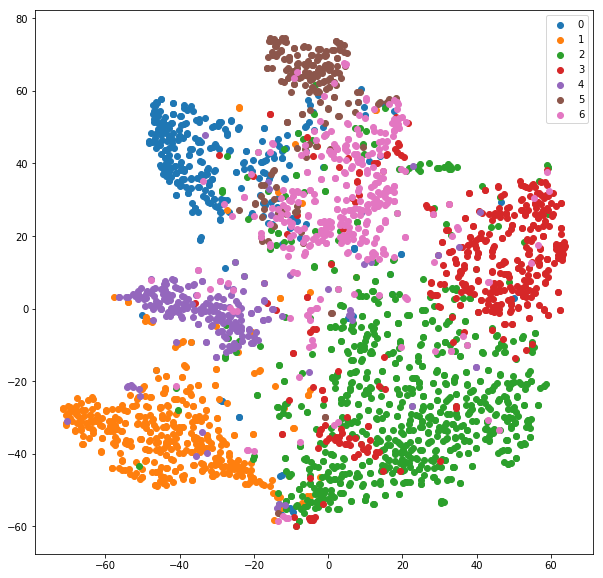

In [40]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = numpy.argmax(labels_encoded, axis=1)
    matplot.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = numpy.where(color_map==cl)
        indices = indices[0]
        matplot.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    matplot.legend()
    matplot.show()
    
plot_tSNE(labels_encoded,x_tsne)

<h2> Comparison to Fully-Connected Neural Networks </h2>

<h3>Building and Training FNN</h3>

In [41]:
es_patience = 100
optimizer = Adam(lr=1e-2)
l2_reg = 5e-4
epochs = 200

#Compare with FNN
#Construct the model
model_fnn = Sequential()
model_fnn.add(Dense(
                    128,
                    input_dim=nodes_features.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.softmax))


model_fnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])


#define TensorBoard
tbCallBack_FNN = TensorBoard(
    log_dir='./Tensorboard_FNN_cora',
)

#Train model
validation_data_fnn = (nodes_features, labels_encoded, val_mask)
model_fnn.fit(
                nodes_features,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=Num_Nodes,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_FNN
          ])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - ETA: 0s - loss: 0.2185 - acc: 0.1357WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000027BFB2C1D08> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

1/1 [==============================] - ETA: 0s - loss: 0.0244 - acc: 0.992 - 0s 216ms/step - loss: 0.0244 - acc: 0.9929 - val_loss: 0.4007 - val_acc: 0.4520
Epoch 39/200
1/1 [==============================] - ETA: 0s - loss: 0.0245 - acc: 0.992 - 0s 193ms/step - loss: 0.0245 - acc: 0.9929 - val_loss: 0.4035 - val_acc: 0.4480
Epoch 40/200
1/1 [==============================] - ETA: 0s - loss: 0.0254 - acc: 0.978 - 0s 152ms/step - loss: 0.0254 - acc: 0.9786 - val_loss: 0.3942 - val_acc: 0.4520
Epoch 41/200
1/1 [==============================] - ETA: 0s - loss: 0.0257 - acc: 0.985 - 0s 172ms/step - loss: 0.0257 - acc: 0.9857 - val_loss: 0.3823 - val_acc: 0.4740
Epoch 42/200
1/1 [==============================] - ETA: 0s - loss: 0.0247 - acc: 1.000 - 0s 207ms/step - loss: 0.0247 - acc: 1.0000 - val_loss: 0.3650 - val_acc: 0.4920
Epoch 43/200
1/1 [==============================] - ETA: 0s - loss: 0.0242 - acc: 0.992 - 0s 160ms/step - loss: 0.0242 - acc: 0.9929 - val_loss: 0.3534 - val_acc: 

1/1 [==============================] - ETA: 0s - loss: 0.0253 - acc: 0.992 - 0s 156ms/step - loss: 0.0253 - acc: 0.9929 - val_loss: 0.3985 - val_acc: 0.4820
Epoch 87/200
1/1 [==============================] - ETA: 0s - loss: 0.0265 - acc: 0.985 - 0s 161ms/step - loss: 0.0265 - acc: 0.9857 - val_loss: 0.3986 - val_acc: 0.4800
Epoch 88/200
1/1 [==============================] - ETA: 0s - loss: 0.0268 - acc: 0.985 - 0s 162ms/step - loss: 0.0268 - acc: 0.9857 - val_loss: 0.4051 - val_acc: 0.4780
Epoch 89/200
1/1 [==============================] - ETA: 0s - loss: 0.0268 - acc: 0.978 - 0s 162ms/step - loss: 0.0268 - acc: 0.9786 - val_loss: 0.4166 - val_acc: 0.4560
Epoch 90/200
1/1 [==============================] - ETA: 0s - loss: 0.0299 - acc: 0.978 - 0s 157ms/step - loss: 0.0299 - acc: 0.9786 - val_loss: 0.4146 - val_acc: 0.4680
Epoch 91/200
1/1 [==============================] - ETA: 0s - loss: 0.0270 - acc: 0.992 - 0s 162ms/step - loss: 0.0270 - acc: 0.9929 - val_loss: 0.4163 - val_acc: 

In [42]:
# Evaluate model
y_pred = model_fnn.predict(X_te)
report = classification_report(numpy.argmax(y_te,axis=1), numpy.argmax(y_pred,axis=1), target_names=classes)
print('FCNN Classification Report: \n {}'.format(report))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
FCNN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.55      0.60      0.57       114
    Genetic_Algorithms       0.73      0.74      0.74       159
       Neural_Networks       0.74      0.44      0.55       302
 Probabilistic_Methods       0.50      0.59      0.54       156
Reinforcement_Learning     

<h3>Get hidden layer representation for FNN</h3>

In [43]:
layer_outputs = [layer.output for layer in model_fnn.layers] 
activation_model = Model(inputs=model_fnn.input, outputs=layer_outputs)
activations = activation_model.predict([nodes_features])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


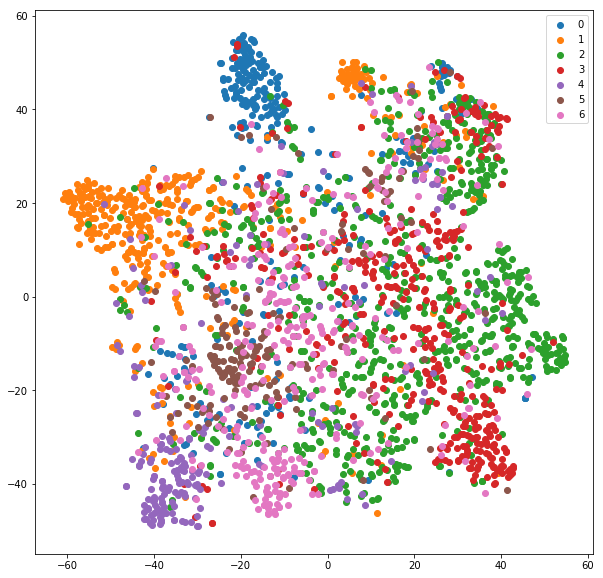

In [44]:
x_tsne = TSNE(n_components=2).fit_transform(activations[3])
plot_tSNE(labels_encoded,x_tsne)

In [45]:
### END OF NOTEBOOK ###

# Build and Train with Graph Attention Networks

In [46]:
channels = 48           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-4    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 100       # Patience for early stopping

# Preprocessing operations
A = GATConv.preprocess(Adjacency).astype('f4')

In [47]:
# Model definition
X_in = Input(shape=(Num_Nodes_Features, ))
fltr_in = Input((Num_Nodes, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_Attn_1 = GATConv(channels,
                         activation='relu',
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_Attn_1)
graph_Attn_2 = GATConv(24,
                         activation='relu',
                         use_bias=False)([dropout_2, fltr_in])


dropout_3 = Dropout(dropout)(graph_Attn_2)
graph_Attn_3 = GATConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_3, fltr_in])




Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [48]:
fltr_in

<KerasTensor: type_spec=SparseTensorSpec(TensorShape([None, 2708]), tf.float32) (created by layer 'input_4')>

In [49]:
# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_Attn_3)

In [50]:
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GAT = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GAT_cora',
)
callback_GAT = [tbCallBack_GAT]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1433)         0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
gat_conv (GATConv)              (None, 48)           68880       dropout_5[0][0]                  
                                                                 input_4[0][0]              

In [51]:
model.fit([nodes_features, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=Num_Nodes,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GAT
          ])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\Sidsavi\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/gat_conv_2/Reshape_5:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_3/gat_conv_2/Reshape_4:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/gat_conv_2/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\Sidsavi\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/gat_conv_2/Reshape_8:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_3/gat_conv_2/Reshape_7:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/gat_conv_2/Cast_2:0", shape=(2,), dtype=i

1/1 [==============================] - ETA: 0s - loss: 0.1006 - acc: 0.1071WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000027B800A82F0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 6s 6s/step - loss: 0.1006 - acc: 0.1071 - val_loss: 0.3593 - val_acc: 0.0920
Epoch 2/200
1/1 [=================

Epoch 44/200
1/1 [==============================] - ETA: 0s - loss: 0.1005 - acc: 0.321 - 0s 301ms/step - loss: 0.1005 - acc: 0.3214 - val_loss: 0.3590 - val_acc: 0.5060
Epoch 45/200
1/1 [==============================] - ETA: 0s - loss: 0.1005 - acc: 0.328 - 1s 540ms/step - loss: 0.1005 - acc: 0.3286 - val_loss: 0.3590 - val_acc: 0.5080
Epoch 46/200
1/1 [==============================] - ETA: 0s - loss: 0.1005 - acc: 0.328 - 0s 346ms/step - loss: 0.1005 - acc: 0.3286 - val_loss: 0.3590 - val_acc: 0.5120
Epoch 47/200
1/1 [==============================] - ETA: 0s - loss: 0.1005 - acc: 0.264 - 0s 326ms/step - loss: 0.1005 - acc: 0.2643 - val_loss: 0.3589 - val_acc: 0.5080
Epoch 48/200
1/1 [==============================] - ETA: 0s - loss: 0.1005 - acc: 0.342 - 0s 339ms/step - loss: 0.1005 - acc: 0.3429 - val_loss: 0.3589 - val_acc: 0.5100
Epoch 49/200
1/1 [==============================] - ETA: 0s - loss: 0.1005 - acc: 0.321 - 0s 326ms/step - loss: 0.1005 - acc: 0.3214 - val_loss: 0.358

1/1 [==============================] - ETA: 0s - loss: 0.1000 - acc: 0.364 - 0s 293ms/step - loss: 0.1000 - acc: 0.3643 - val_loss: 0.3579 - val_acc: 0.4860
Epoch 93/200
1/1 [==============================] - ETA: 0s - loss: 0.1000 - acc: 0.414 - 0s 292ms/step - loss: 0.1000 - acc: 0.4143 - val_loss: 0.3579 - val_acc: 0.4800
Epoch 94/200
1/1 [==============================] - ETA: 0s - loss: 0.1000 - acc: 0.392 - 0s 289ms/step - loss: 0.1000 - acc: 0.3929 - val_loss: 0.3579 - val_acc: 0.4820
Epoch 95/200
1/1 [==============================] - ETA: 0s - loss: 0.1000 - acc: 0.350 - 0s 300ms/step - loss: 0.1000 - acc: 0.3500 - val_loss: 0.3578 - val_acc: 0.4780
Epoch 96/200
1/1 [==============================] - ETA: 0s - loss: 0.1001 - acc: 0.371 - 0s 295ms/step - loss: 0.1001 - acc: 0.3714 - val_loss: 0.3578 - val_acc: 0.4780
Epoch 97/200
1/1 [==============================] - ETA: 0s - loss: 0.0999 - acc: 0.421 - 0s 289ms/step - loss: 0.0999 - acc: 0.4214 - val_loss: 0.3578 - val_acc: 

Epoch 140/200
1/1 [==============================] - ETA: 0s - loss: 0.0989 - acc: 0.450 - 0s 293ms/step - loss: 0.0989 - acc: 0.4500 - val_loss: 0.3560 - val_acc: 0.4360
Epoch 141/200
1/1 [==============================] - ETA: 0s - loss: 0.0992 - acc: 0.435 - 0s 290ms/step - loss: 0.0992 - acc: 0.4357 - val_loss: 0.3559 - val_acc: 0.4360
Epoch 142/200
1/1 [==============================] - ETA: 0s - loss: 0.0992 - acc: 0.328 - 0s 290ms/step - loss: 0.0992 - acc: 0.3286 - val_loss: 0.3559 - val_acc: 0.4360
Epoch 143/200
1/1 [==============================] - ETA: 0s - loss: 0.0989 - acc: 0.385 - 0s 288ms/step - loss: 0.0989 - acc: 0.3857 - val_loss: 0.3558 - val_acc: 0.4360
Epoch 144/200
1/1 [==============================] - ETA: 0s - loss: 0.0988 - acc: 0.457 - 0s 298ms/step - loss: 0.0988 - acc: 0.4571 - val_loss: 0.3558 - val_acc: 0.4340
Epoch 145/200
1/1 [==============================] - ETA: 0s - loss: 0.0993 - acc: 0.378 - 0s 288ms/step - loss: 0.0993 - acc: 0.3786 - val_loss:

Epoch 188/200
1/1 [==============================] - ETA: 0s - loss: 0.0975 - acc: 0.407 - 0s 294ms/step - loss: 0.0975 - acc: 0.4071 - val_loss: 0.3526 - val_acc: 0.4360
Epoch 189/200
1/1 [==============================] - ETA: 0s - loss: 0.0977 - acc: 0.392 - 0s 460ms/step - loss: 0.0977 - acc: 0.3929 - val_loss: 0.3526 - val_acc: 0.4360
Epoch 190/200
1/1 [==============================] - ETA: 0s - loss: 0.0974 - acc: 0.400 - 0s 300ms/step - loss: 0.0974 - acc: 0.4000 - val_loss: 0.3525 - val_acc: 0.4360
Epoch 191/200
1/1 [==============================] - ETA: 0s - loss: 0.0977 - acc: 0.428 - 0s 388ms/step - loss: 0.0977 - acc: 0.4286 - val_loss: 0.3524 - val_acc: 0.4360
Epoch 192/200
1/1 [==============================] - ETA: 0s - loss: 0.0984 - acc: 0.357 - 0s 373ms/step - loss: 0.0984 - acc: 0.3571 - val_loss: 0.3523 - val_acc: 0.4360
Epoch 193/200
1/1 [==============================] - ETA: 0s - loss: 0.0972 - acc: 0.414 - 0s 300ms/step - loss: 0.0972 - acc: 0.4143 - val_loss:

In [52]:
y_pred = model.predict([nodes_features,A], batch_size=Num_Nodes)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\Sidsavi\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.24      0.98      0.38       298
    Genetic_Algorithms       0.00      0.00      0.00       418
       Neural_Networks       0.90      0.63      0.74       818
 Probabilistic_Methods       0.94      0.68      0.79       426
Reinforcement_Learning       0.00      0.00      0.00       217
         Rule_Learning       0.24      0.81      0.37       180
                Theory       1.00      0.03      0.06       351

              accuracy                           0.46      2708
             macro avg       0.47      0.45      0.33      2708
          weighted avg       0.59      0.46      0.42      2708

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function 

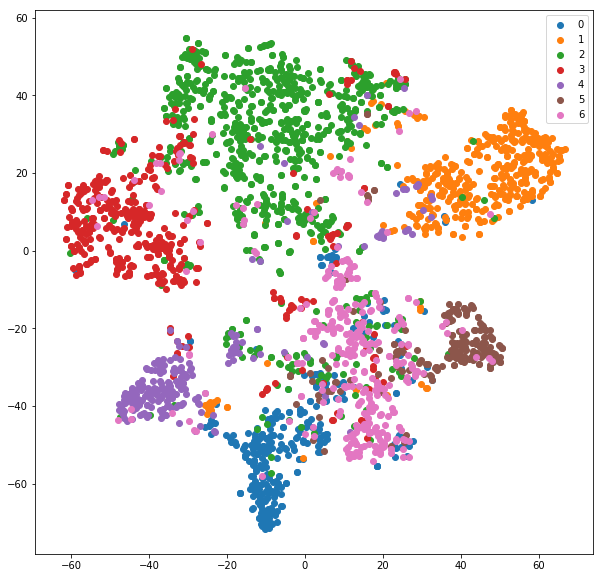

In [53]:
report = classification_report(numpy.argmax(labels_encoded,axis=1), numpy.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

#Get hidden layer representation for GCN </h3>

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict([nodes_features,A],batch_size=Num_Nodes)

activations[3]

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = numpy.argmax(labels_encoded, axis=1)
    matplot.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = numpy.where(color_map==cl)
        indices = indices[0]
        matplot.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    matplot.legend()
    matplot.show()
    
plot_tSNE(labels_encoded,x_tsne)

# Build Model using Graph Sage

In [54]:
from spektral.layers import GraphSageConv

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1433)]       0                                            
________________________________________________________________

C:\Users\Sidsavi\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/graph_sage_conv_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_5/graph_sage_conv_2/Reshape:0", shape=(None, 24), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/graph_sage_conv_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\Sidsavi\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/graph_sage_conv_1/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_5/graph_sage_conv_1/Reshape:0", shape=(None, 48), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/graph_sage

1/1 [==============================] - ETA: 0s - loss: 0.1034 - acc: 0.1286WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000027B80C23B70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 5s 5s/step - loss: 0.1034 - acc: 0.1286 - val_loss: 0.3814 - val_acc: 0.1120
Epoch 2/200
1/1 [=================

Epoch 44/200
1/1 [==============================] - ETA: 0s - loss: 0.0996 - acc: 0.164 - 0s 346ms/step - loss: 0.0996 - acc: 0.1643 - val_loss: 0.3611 - val_acc: 0.1880
Epoch 45/200
1/1 [==============================] - ETA: 0s - loss: 0.0997 - acc: 0.157 - 0s 345ms/step - loss: 0.0997 - acc: 0.1571 - val_loss: 0.3606 - val_acc: 0.1920
Epoch 46/200
1/1 [==============================] - ETA: 0s - loss: 0.1005 - acc: 0.200 - 0s 349ms/step - loss: 0.1005 - acc: 0.2000 - val_loss: 0.3601 - val_acc: 0.1940
Epoch 47/200
1/1 [==============================] - ETA: 0s - loss: 0.1014 - acc: 0.150 - 0s 351ms/step - loss: 0.1014 - acc: 0.1500 - val_loss: 0.3596 - val_acc: 0.1960
Epoch 48/200
1/1 [==============================] - ETA: 0s - loss: 0.1000 - acc: 0.185 - 0s 350ms/step - loss: 0.1000 - acc: 0.1857 - val_loss: 0.3591 - val_acc: 0.1980
Epoch 49/200
1/1 [==============================] - ETA: 0s - loss: 0.1001 - acc: 0.207 - 0s 348ms/step - loss: 0.1001 - acc: 0.2071 - val_loss: 0.358

1/1 [==============================] - ETA: 0s - loss: 0.0956 - acc: 0.307 - 0s 353ms/step - loss: 0.0956 - acc: 0.3071 - val_loss: 0.3342 - val_acc: 0.3100
Epoch 93/200
1/1 [==============================] - ETA: 0s - loss: 0.0947 - acc: 0.314 - 0s 347ms/step - loss: 0.0947 - acc: 0.3143 - val_loss: 0.3336 - val_acc: 0.3160
Epoch 94/200
1/1 [==============================] - ETA: 0s - loss: 0.0958 - acc: 0.285 - 0s 355ms/step - loss: 0.0958 - acc: 0.2857 - val_loss: 0.3331 - val_acc: 0.3160
Epoch 95/200
1/1 [==============================] - ETA: 0s - loss: 0.0973 - acc: 0.242 - 0s 368ms/step - loss: 0.0973 - acc: 0.2429 - val_loss: 0.3327 - val_acc: 0.3160
Epoch 96/200
1/1 [==============================] - ETA: 0s - loss: 0.0945 - acc: 0.314 - 0s 417ms/step - loss: 0.0945 - acc: 0.3143 - val_loss: 0.3322 - val_acc: 0.3200
Epoch 97/200
1/1 [==============================] - ETA: 0s - loss: 0.0954 - acc: 0.292 - 0s 350ms/step - loss: 0.0954 - acc: 0.2929 - val_loss: 0.3317 - val_acc: 

Epoch 140/200
1/1 [==============================] - ETA: 0s - loss: 0.0910 - acc: 0.378 - 0s 324ms/step - loss: 0.0910 - acc: 0.3786 - val_loss: 0.3130 - val_acc: 0.4260
Epoch 141/200
1/1 [==============================] - ETA: 0s - loss: 0.0904 - acc: 0.342 - 0s 373ms/step - loss: 0.0904 - acc: 0.3429 - val_loss: 0.3126 - val_acc: 0.4280
Epoch 142/200
1/1 [==============================] - ETA: 0s - loss: 0.0923 - acc: 0.357 - 0s 320ms/step - loss: 0.0923 - acc: 0.3571 - val_loss: 0.3121 - val_acc: 0.4340
Epoch 143/200
1/1 [==============================] - ETA: 0s - loss: 0.0904 - acc: 0.392 - 0s 346ms/step - loss: 0.0904 - acc: 0.3929 - val_loss: 0.3117 - val_acc: 0.4380
Epoch 144/200
1/1 [==============================] - ETA: 0s - loss: 0.0900 - acc: 0.414 - 0s 353ms/step - loss: 0.0900 - acc: 0.4143 - val_loss: 0.3112 - val_acc: 0.4380
Epoch 145/200
1/1 [==============================] - ETA: 0s - loss: 0.0893 - acc: 0.414 - 0s 373ms/step - loss: 0.0893 - acc: 0.4143 - val_loss:

Epoch 188/200
1/1 [==============================] - ETA: 0s - loss: 0.0881 - acc: 0.435 - 0s 354ms/step - loss: 0.0881 - acc: 0.4357 - val_loss: 0.2962 - val_acc: 0.5680
Epoch 189/200
1/1 [==============================] - ETA: 0s - loss: 0.0867 - acc: 0.485 - 0s 392ms/step - loss: 0.0867 - acc: 0.4857 - val_loss: 0.2959 - val_acc: 0.5700
Epoch 190/200
1/1 [==============================] - ETA: 0s - loss: 0.0869 - acc: 0.485 - 0s 385ms/step - loss: 0.0869 - acc: 0.4857 - val_loss: 0.2957 - val_acc: 0.5740
Epoch 191/200
1/1 [==============================] - ETA: 0s - loss: 0.0880 - acc: 0.414 - 0s 373ms/step - loss: 0.0880 - acc: 0.4143 - val_loss: 0.2955 - val_acc: 0.5760
Epoch 192/200
1/1 [==============================] - ETA: 0s - loss: 0.0861 - acc: 0.457 - 0s 361ms/step - loss: 0.0861 - acc: 0.4571 - val_loss: 0.2952 - val_acc: 0.5780
Epoch 193/200
1/1 [==============================] - ETA: 0s - loss: 0.0872 - acc: 0.428 - 0s 432ms/step - loss: 0.0872 - acc: 0.4286 - val_loss:

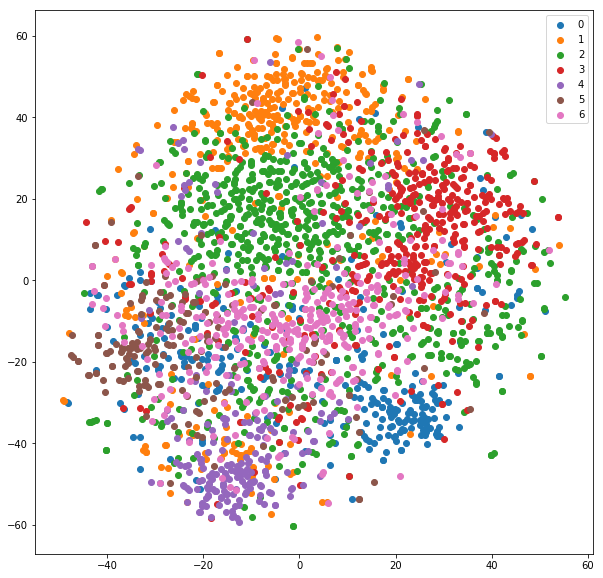

In [55]:
channels = 48           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-4    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 100       # Patience for early stopping

# Preprocessing operations
A = GraphSageConv.preprocess(Adjacency).astype('f4')

# Model definition
X_in = Input(shape=(Num_Nodes_Features, ))
fltr_in = Input((Num_Nodes, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_sage_1 = GraphSageConv(channels,
                         activation='relu',
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_sage_1)
graph_sage_2 = GraphSageConv(24,
                         activation='relu',
                         use_bias=False)([dropout_2, fltr_in])


dropout_3 = Dropout(dropout)(graph_sage_2)
graph_sage_3 = GraphSageConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_3, fltr_in])




fltr_in

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_sage_3)

optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_sage = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_sage_cora',
)
callback_sage = [tbCallBack_sage]

model.fit([nodes_features, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=Num_Nodes,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_sage
          ])

y_pred = model.predict([nodes_features,A], batch_size=Num_Nodes)

report = classification_report(numpy.argmax(labels_encoded,axis=1), numpy.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

#Get hidden layer representation for GCN </h3>

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict([nodes_features,A],batch_size=Num_Nodes)

activations[3]

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = numpy.argmax(labels_encoded, axis=1)
    matplot.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = numpy.where(color_map==cl)
        indices = indices[0]
        matplot.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    matplot.legend()
    matplot.show()
    
plot_tSNE(labels_encoded,x_tsne)


In [56]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 1433)         0           input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
graph_sage_conv (GraphSageConv) (None, 48)           137568      dropout_8[0][0]                  
                                                                 input_6[0][0]              